In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/massachusetts-roads-dataset/label_class_dict.csv
/kaggle/input/massachusetts-roads-dataset/metadata.csv
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/10978735_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/10228690_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/24328810_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/22528900_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/25229230_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/10978795_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/25229245_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/22978990_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/18028945_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/24179245_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/24929245_15.tif
/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/21929020_1

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
import random


In [25]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = "../input/massachusetts-roads-dataset/tiff/train/"
TRAIN_MASK_PATH = "../input/massachusetts-roads-dataset/tiff/train_labels/"

VAL_PATH = "../input/massachusetts-roads-dataset/tiff/val/"
VAL_MASK_PATH = "../input/massachusetts-roads-dataset/tiff/val_labels/"

TEST_PATH = '../input/massachusetts-roads-dataset/tiff/test/'


In [4]:
train_imgs = sorted(os.listdir(TRAIN_PATH))
train_masks = sorted(os.listdir(TRAIN_MASK_PATH))

val_imgs = sorted(os.listdir(VAL_PATH))
val_masks = sorted(os.listdir(VAL_MASK_PATH))


In [5]:
X_train = np.zeros((len(train_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print("Processing training data...")

for i, file_name in tqdm(enumerate(train_imgs), total=len(train_imgs)):
    img = imread(os.path.join(TRAIN_PATH, file_name))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    mask = imread(os.path.join(TRAIN_MASK_PATH, train_masks[i]))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)
    Y_train[i] = mask > 0.5


Processing training data...


100%|██████████| 1108/1108 [07:17<00:00,  2.53it/s]


In [6]:
#for validation set
X_val = np.zeros((len(val_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((len(val_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print("Processing validation data...")

for i, file_name in tqdm(enumerate(val_imgs), total=len(val_imgs)):
    img = imread(os.path.join(VAL_PATH, file_name))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_val[i] = img

    mask = imread(os.path.join(VAL_MASK_PATH, val_masks[i]))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)
    Y_val[i] = mask > 0.5


Processing validation data...


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


In [7]:
test_imgs = sorted(os.listdir(TEST_PATH))

X_test = np.zeros((len(test_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print("Processing test data...")

for i, file_name in tqdm(enumerate(test_imgs), total=len(test_imgs)):
    img = imread(os.path.join(TEST_PATH, file_name))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img


Processing test data...


100%|██████████| 49/49 [00:15<00:00,  3.23it/s]


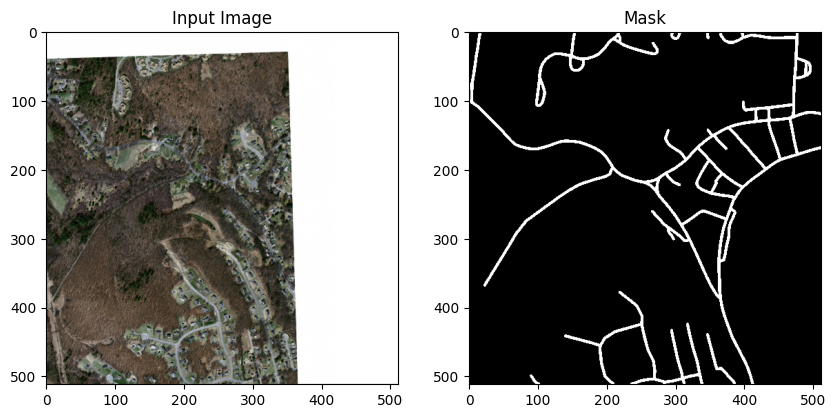

In [8]:
ix = random.randint(0, len(X_train) - 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(X_train[ix])
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(Y_train[ix].squeeze(), cmap='gray')
plt.title("Mask")
plt.show()


In [9]:
#BUILDING THE U-NET MODEL

inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

#CONVOLUTION LAYERS
#c = tf.keras.layers.Conv2D(feature size, kernel size, activation,kernel_initializer(he_normal usese normal distribution for assigning initial weights to nn),padding)(on what we should apply this)

#layers takes in only floating point values so change img_width, ... to float by dividing by 255 as image values go from 0 to 255

s=tf.keras.layers.Lambda(lambda x: x/255)(inputs)

c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer ='he_normal',padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1) #dropout of 10% to prevent overfitting
c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer ='he_normal',padding = 'same')(c1)
#maxpooling poolsize= 2x2
p1 = tf.keras.layers.MaxPooling2D(2,2)(c1) 

c2 = tf.keras.layers.Conv2D(32,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(2,2)(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(2,2)(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(2,2)(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation= 'relu',kernel_initializer = 'he_normal',padding ='same')(c5)
#no pool for the last layer of  Downsampling

#explanding path /upsampling
#note conv size for upsampling is 2x2 acc to image
u6= tf.keras.layers.Conv2DTranspose(128,(2,2),strides= (2,2),padding ='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(c6)

u7= tf.keras.layers.Conv2DTranspose(64,(2,2),strides= (2,2),padding ='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides= (2,2),padding ='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides= (2,2),padding ='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1],axis =3)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation ='relu',kernel_initializer = 'he_normal',padding = 'same')(c9)

#for o/p as per picture, feature size =1 and conv kernel size also is 1x1
outputs = tf.keras.layers.Conv2D(1,(1,1),activation = 'sigmoid')(c9)

#saving and compiling the model

model = tf.keras.Model(inputs=[inputs],outputs =[outputs])
model.compile(optimizer = 'adam',loss ='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 512, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#model checkpoint

checkpointer=tf.keras.callbacks.ModelCheckpoint('unet_best_model.keras',verbose=1,save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=2),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer
]

results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=16, epochs=25,callbacks=callbacks)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8972 - loss: 0.3803
Epoch 1: val_loss improved from inf to 0.25039, saving model to unet_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8973 - loss: 0.3794 - val_accuracy: 0.9491 - val_loss: 0.2504
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9088 - loss: 0.2575
Epoch 2: val_loss improved from 0.25039 to 0.20958, saving model to unet_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 585ms/step - accuracy: 0.9088 - loss: 0.2575 - val_accuracy: 0.9491 - val_loss: 0.2096
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9056 - loss: 0.2438
Epoch 3: val_loss improved from 0.20958 to 0.20682, saving model to unet_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step - accuracy: 0.9056 - loss: 0.2437 - val_accuracy: 0.9491 - val_loss: 0.2068
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9183 - loss: 0.2238
Epoch 4: val_loss improved from 0.2068

In [11]:
preds_train_t = model.predict(X_train, batch_size=16) 
preds_val_t = model.predict(X_val, batch_size=16)    

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


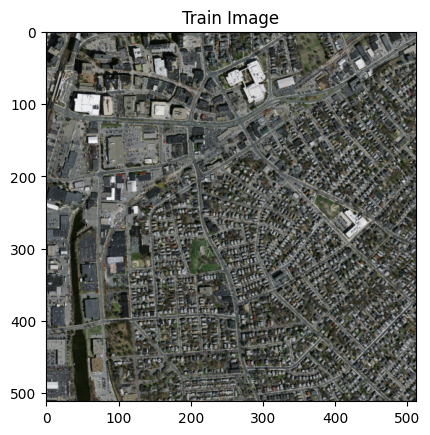

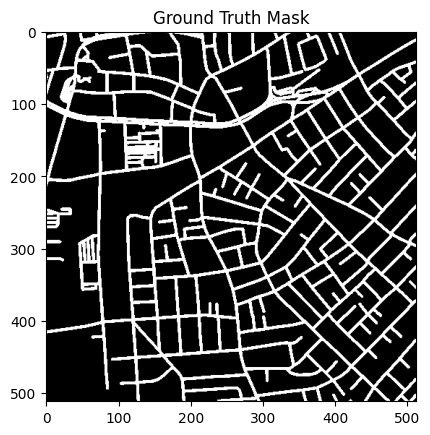

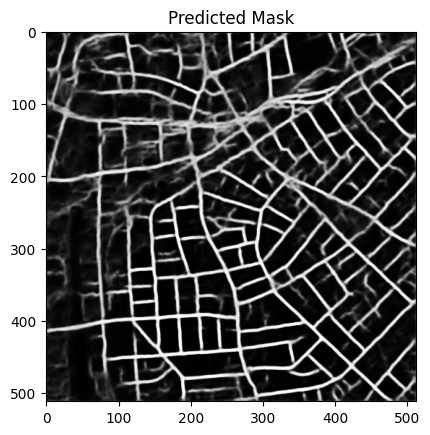

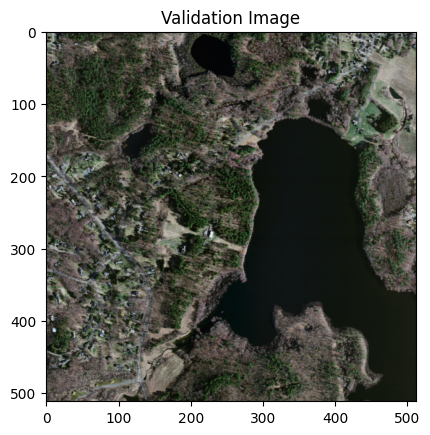

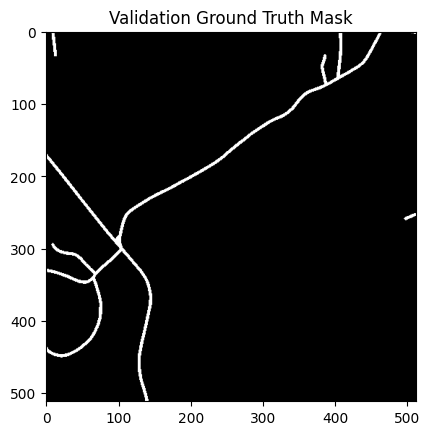

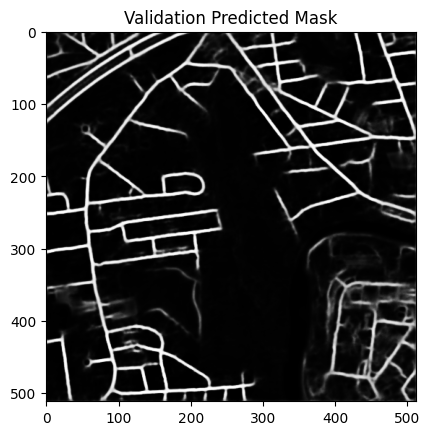

In [12]:
ix = random.randint(0,len(preds_train_t)-1)

plt.imshow(X_train[ix])
plt.title("Train Image")
plt.show()

plt.imshow(np.squeeze(Y_train[ix]), cmap='gray')
plt.title("Ground Truth Mask")
plt.show()

plt.imshow(np.squeeze(preds_train_t[ix]), cmap='gray')
plt.title("Predicted Mask")
plt.show()

# For validation
ix = random.randint(0,len(preds_val_t)-1)

plt.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.title("Validation Image")
plt.show()

plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]), cmap='gray')
plt.title("Validation Ground Truth Mask")
plt.show()

plt.imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
plt.title("Validation Predicted Mask")
plt.show()


In [13]:
def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.7):
    overlay = image.copy()
    mask = np.squeeze(mask)

    if len(mask.shape) == 2:  # make sure it's 2D
        mask = mask.astype(bool)

    overlay[mask] = (1 - alpha) * overlay[mask] + alpha * np.array(color)
    return overlay.astype(np.uint8)


In [14]:
# Generate test predictions (AFTER loading model)
preds_test_t = model.predict(X_test, batch_size=16)

# Threshold predictions to binary mask
preds_test_t = (preds_test_t > 0.5).astype(np.float32)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  


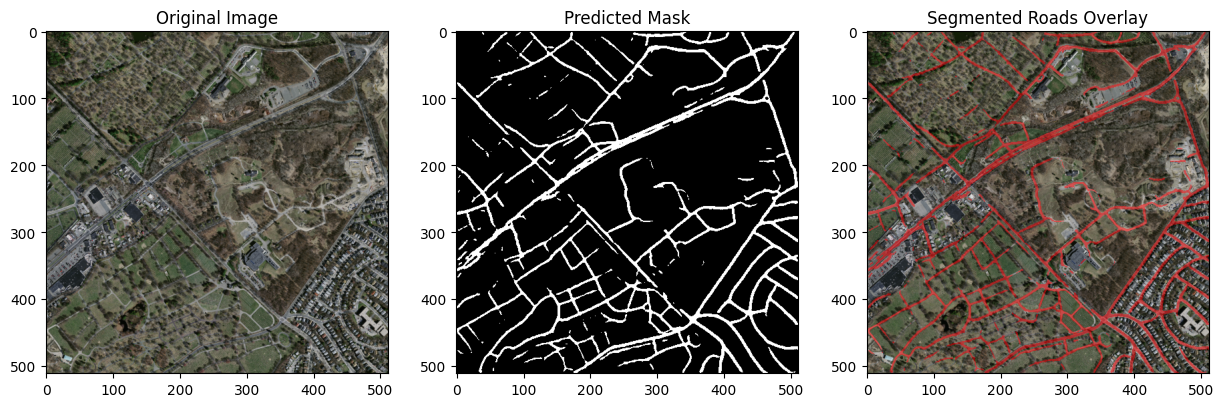

In [15]:
ix = random.randint(0, len(X_test) - 1)
original_image = X_test[ix]
predicted_mask = preds_test_t[ix]
predicted_mask = tf.image.resize(predicted_mask, (512, 512)).numpy()

highlighted = overlay_mask_on_image(original_image, predicted_mask, color=(255, 0, 0), alpha=0.5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.title("Predicted Mask")

plt.subplot(1, 3, 3)
plt.imshow(highlighted)
plt.title("Segmented Roads Overlay")

plt.show()


In [16]:
#ROAD TYPE CLASSIFICATION 

road_types = ['Highway', 'Main Road', 'Street', 'Dirt Road']

import cv2

from tensorflow.image import resize

def extract_road_patch(img, mask):
    mask = tf.image.resize(mask, (img.shape[0], img.shape[1]))  # Resize to 512x512
    mask = tf.squeeze(mask).numpy() > 0.5                       # Threshold to boolean mask
    img = (img * 255).astype(np.uint8)                          # Convert to uint8 if needed
    patch = img.copy()
    patch[~mask] = 0
    return patch


road_patches = []
for i in range(len(preds_train_t)):
    road_patches.append(extract_road_patch(X_train[i], preds_train_t[i]))
road_patches = np.array(road_patches)


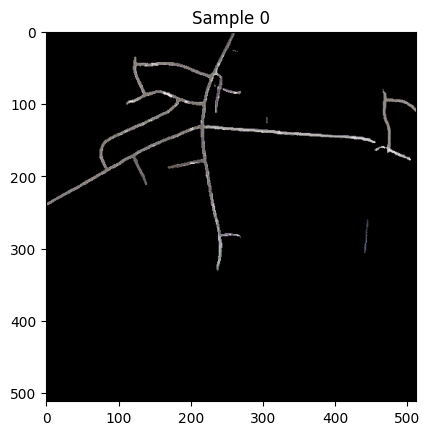

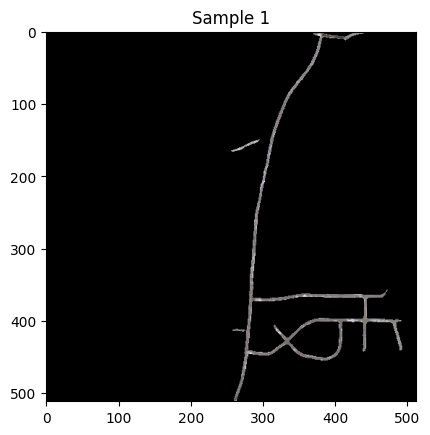

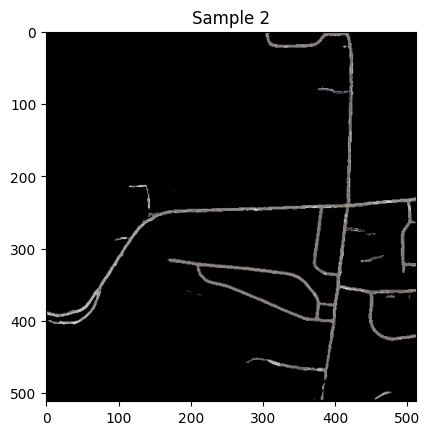

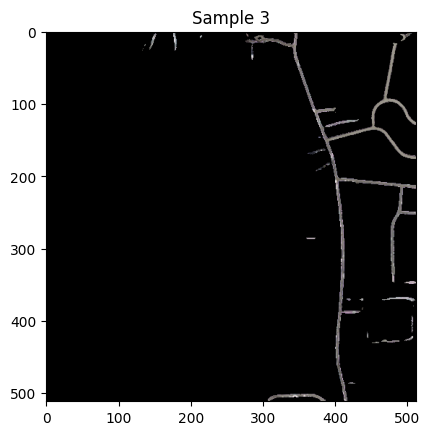

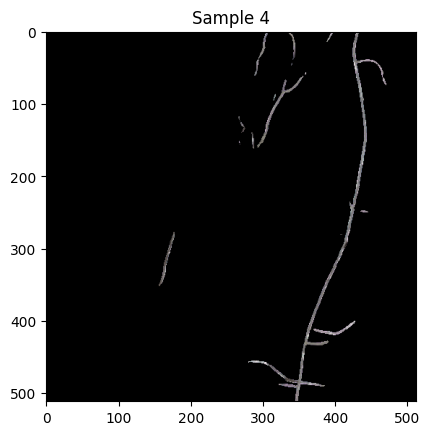

In [17]:
for i in range(5):
    patch = extract_road_patch(X_train[i], preds_train_t[i])
    plt.imshow(patch)
    plt.title(f"Sample {i}")
    plt.show()


In [18]:
from sklearn.ensemble import RandomForestClassifier
from skimage.measure import regionprops, label
from sklearn.preprocessing import StandardScaler
import cv2

# Sample training data for classifier (you must build real data here)
X_cls_train = []
y_cls_train = []

# Dummy classifier setup
clf = RandomForestClassifier()

def extract_features(mask):
    mask = mask.squeeze().astype(np.uint8)
    labeled_mask = label(mask)
    props = regionprops(labeled_mask)
    
    if not props:
        return [0, 0, 0, 0]
    
    largest_region = max(props, key=lambda x: x.area)
    
    area = largest_region.area
    eccentricity = largest_region.eccentricity
    solidity = largest_region.solidity
    extent = largest_region.extent
    
    return [area, eccentricity, solidity, extent]

# Dummy training loop
for i in range(len(Y_train)):
    features = extract_features(Y_train[i])
    label_type = np.random.choice(road_types)  # Replace with real labels if available
    X_cls_train.append(features)
    y_cls_train.append(road_types.index(label_type))

# Train the classifier
scaler = StandardScaler()
X_cls_train_scaled = scaler.fit_transform(X_cls_train)
clf.fit(X_cls_train_scaled, y_cls_train)

# Predict road type from new test mask
ix = random.randint(0, len(preds_test_t)-1)
test_mask = preds_test_t[ix]
features_test = extract_features(test_mask)
features_test_scaled = scaler.transform([features_test])
predicted_road_type = road_types[clf.predict(features_test_scaled)[0]]

print("Predicted Road Type:", predicted_road_type)


Predicted Road Type: Street


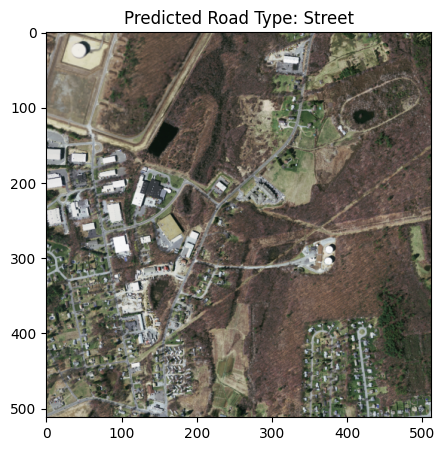

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(X_test[ix])
plt.title(f"Predicted Road Type: {predicted_road_type}")
plt.show()


In [20]:
from IPython.display import FileLink
FileLink('unet_best_model.keras')  # Creates downloadable link


/kaggle/working/unet_best_model.keras

In [21]:
# In Kaggle notebook only
import pickle
import tempfile

# Enable Keras pickling
def make_keras_picklable():
    def __getstate__(self):
        with tempfile.NamedTemporaryFile(suffix='.keras') as tmp:
            self.save(tmp.name)
            return {'model_str': tmp.read()}
    
    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.keras') as tmp:
            tmp.write(state['model_str'])
            model = tf.keras.models.load_model(tmp.name)
            self.__dict__.update(model.__dict__)
            
    tf.keras.Model.__getstate__ = __getstate__
    tf.keras.Model.__setstate__ = __setstate__

make_keras_picklable()

# Save as PKL
with open('unet_roads.pkl', 'wb') as f:
    pickle.dump(model, f)


In [22]:
with open('unet_roads.pkl','rb') as f:
    pkl_model = pickle.load(f)
assert np.allclose(model.predict(X_test), pkl_model.predict(X_test))


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 22s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
